## Inspecting Data

In [1]:
import gen_input

import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [3]:
train_test_valid_split = [1., 0., 0.]
# From http://ufldl.stanford.edu/housenumbers/
svhn_train = gen_input.read_data_sets("data/train_32x32.mat", train_test_valid_split).train
svhn_test = gen_input.read_data_sets("data/test_32x32.mat", train_test_valid_split).train

print svhn_train.images[0].shape
print svhn_train.images.shape
print svhn_test.images[0].shape
print svhn_test.images.shape

(1024, 3)
(73257, 1024, 3)
(1024, 3)
(26032, 1024, 3)


In [4]:
per_img_means = svhn_train.images.mean(axis=1)
# per_img_norm = svhn_train.images - per_img_means[:, np.newaxis, :]

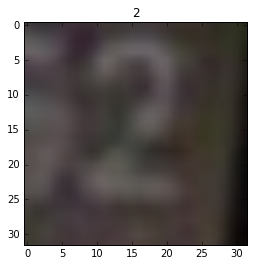

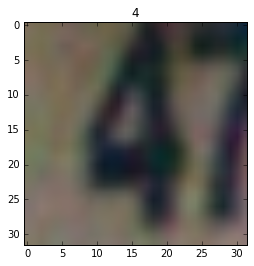

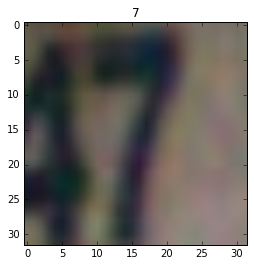

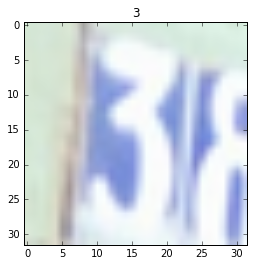

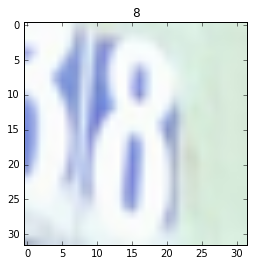

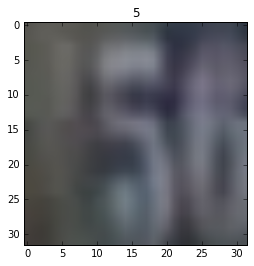

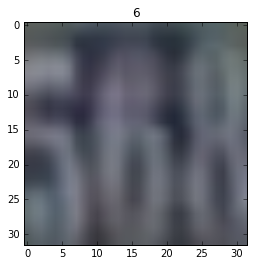

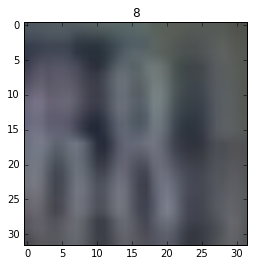

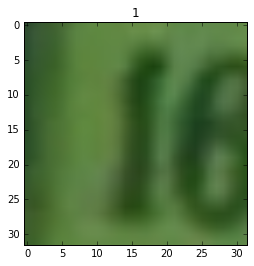

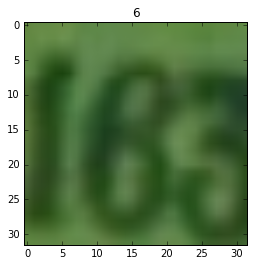

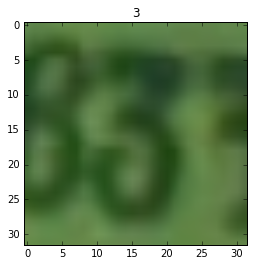

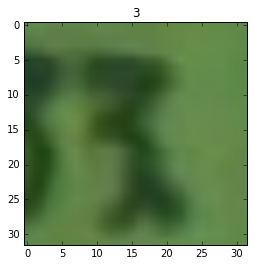

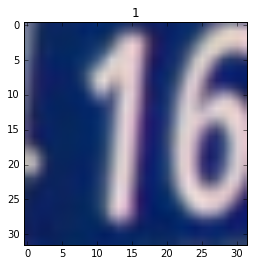

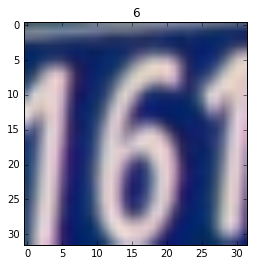

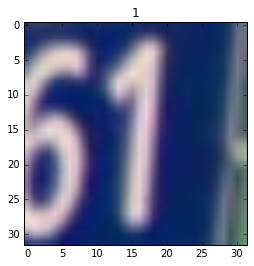

In [6]:
for i in range(4010, 4025):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    img = svhn_train.images[i]
    lbl = np.argmax(svhn_train.labels[i])
    ax.set_title(lbl)
    img = img.reshape([32,32,3])
    imgplot = plt.imshow(img)
    plt.show()
    
#     img_s = per_img_norm[i]
#     img_s = img_s.reshape([32,32,3])
#     imgplot = plt.imshow(img_s)
#     plt.show()

## Model

In [7]:
# Data information
n_input = 1024 # SVHN data input (img shape: 32*32)
n_classes = 10 # total classes (0-9 digits)
channels = 3

In [10]:
##########################################
##                                      ##
##              Parameters              ##
##                                      ##
##########################################
# Training Parameters
learning_rate = 1e-3
training_epochs = 2 # <-- 2 for now
batch_size = 100
total_batches = int(0.025 * svhn_train.num_examples / batch_size) # <-- only 2.5% of data for now

# 1 - drop out 
train_keep_prob = 0.9

In [11]:
ts = datetime.now().strftime('%Y%m%d_%H%M')
logs_path = "logs/{}/".format(ts)

##########################################
##                                      ##
##            Helper Wrappers           ##
##                                      ##
##########################################
# Conv2D wrapper, with bias and relu activation
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, 
                     strides=[1, strides, strides, 1], 
                     padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# MaxPool2D wrapper
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, 
                          ksize=[1, k, k, 1], 
                          strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, keep_prob):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 32, 32, channels])

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    tf.summary.histogram("conv1", conv1)

    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    tf.summary.histogram("conv2", conv2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Output classes
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

        
##########################################
##                                      ##
##            Variable Scopes           ##
##            (for neatness)            ##
##########################################

# RESET TF GRAPH, just in case
tf.reset_default_graph()

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=[None, n_input, channels], name="x_input") 
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name="y_actual")

with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)

with tf.name_scope('weights'):
    weights = {
        # 5x5 conv, 1 input, 32 outputs
        'wc1': tf.Variable(tf.random_normal([5, 5, channels, 32]), name="weights_conv1"), # 32
        # 5x5 conv, 32 inputs, 64 outputs
        'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]), name="weights_conv2"), # 16
        # fully connected, 7*7*64 inputs, 1024 outputs
        'wd1': tf.Variable(tf.random_normal([8*8*64, 4096]), name="weights_fc1"), # 8
        # 1024 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.random_normal([4096, n_classes]), name="weights_output")
    }

with tf.name_scope('biases'):
    biases = {
        'bc1': tf.Variable(tf.random_normal([32]), name="bias_conv1"),
        'bc2': tf.Variable(tf.random_normal([64]), name="bias_conv2"),
        'bd1': tf.Variable(tf.random_normal([4096]), name="bias_fc1"),
        'out': tf.Variable(tf.random_normal([n_classes]), name="bias_output")
    }

with tf.name_scope('Model'):
    y_ = conv_net(x, weights, biases, keep_prob)
    
with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_, labels=y))

with tf.name_scope('Accuracy'):
    accuracy = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

with tf.name_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Op to calculate every variable gradient
    grads = tf.gradients(loss, tf.trainable_variables())
    grads = list(zip(grads, tf.trainable_variables()))
    
    # Op to update all variables according to their gradient
    apply_grads = optimizer.apply_gradients(grads_and_vars=grads)

    

# Initializing the variables
init = tf.global_variables_initializer()


##########################################
##                                      ##
##               Metrics                ##
##           (for tensorboard)          ##
##########################################
# Summaries to visualize loss & accuracy
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)

# Summaries to visualize weights
for var in tf.trainable_variables():
    var_name = var.name.replace(":", "_") # to suppress the pesky warning
    tf.summary.histogram(var_name + '_weights', var)
    
# Summaries to visualize gradients
for grad, var in grads:
    var_name = var.name.replace(":", "_") # to suppress the pesky warning
    tf.summary.histogram(var_name + '_gradient', grad)

merged_summaries = tf.summary.merge_all()


##########################################
##                                      ##
##           Launch the graph           ##
##                                      ##
##########################################
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

    # TRAINING MODEL
    for epoch in xrange(training_epochs):
        avg_loss = 0.0

        for batch_num in range(total_batches):
            batch_x, batch_y = svhn_train.next_batch(batch_size)
            _, batch_loss, batch_summary = sess.run([apply_grads, loss, merged_summaries],
                                                    feed_dict={x: batch_x, 
                                                               y: batch_y,
                                                               keep_prob: train_keep_prob})

            summary_writer.add_summary(batch_summary, epoch * total_batches + batch_num)

            avg_loss += batch_loss / total_batches
            
        # Display logs per epoch step
        print "Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_loss)

    print "\nOptimization Finished!\n"

    # TESTING MODEL ACCURACY AGAINST TEST SET
    print "Accuracy:", sess.run(accuracy, feed_dict={x: svhn_test.images[:500], ### 
                                                     y: svhn_test.labels[:500], ### 
                                                     keep_prob: 1.0})
    
    print "-"* 70
    pwd = os.getcwd()+"/"
    print("Run the following to start tensorboard server:\n" \
          "tensorboard --logdir=/{}{}".format(pwd, logs_path))

KeyboardInterrupt: 